# Scientific Notebook: SEPP Model Simulation on Real Chicago Data (Sliding Windows)

## Purpose
This notebook is designed to process real-world crime data from Chicago and apply the Self Exciting Point Process (SEPP) predictive model using a sliding time window approach. It focuses on utilizing the pre-processed Chicago data and generating predictions specifically for the SEPP model under this windowing strategy, intended for subsequent evaluation or analysis.

## Workflow Stage
This notebook is in the Model Simulation / Prediction Generation stage. It takes pre-processed real data and runs a specific model configuration (SEPP with sliding windows) to produce spatio-temporal predictions for further steps in the research workflow.

## About
This notebook handles real crime data from Chicago and implements the SEPP prediction process using temporal windows to generate spatial intensity predictions over time. It builds upon the data processing steps performed in previous notebooks.

### 1. Initial Setup, Library Imports, and Path Configuration
This block performs initial setup, including importing libraries for data handling, geospatial operations, and utilities. It conditionally mounts Google Drive and defines project-specific paths based on the execution environment (Colab or local), adding them to the system path. Finally, it conditionally changes the current working directory to the Chicago data location.

In [ ]:
# Import necessary libraries
import geopandas as gpd # For working with geospatial data
import pandas as pd # For data manipulation and analysis
import numpy as np # For numerical operations
import random # For random number generation (if used later)
import sys, os.path, os # For system and path operations
from tqdm import tqdm # For progress bars
import pickle as pkl # For loading/saving Python objects
from shapely.geometry import Point,Polygon # For geometric objects
import dateutil.parser # For parsing dates

# Import modules from datetime for date/time handling
from datetime import datetime, timedelta

# Conditional setup for Google Colab or local environment
# Handles mounting Google Drive and defining project paths based on environment
try:
    # Attempt to import drive from google.colab (runs in Colab)
    from google.colab import drive
    # Mount Google Drive to access files
    drive.mount('/content/drive')

    # Define paths relative to the mounted Google Drive
    # These paths point to directories containing custom libraries/scripts.
    path_opencp="drive/.../Librerias/PredictCode/"
    path_fairness="drive/.../Librerias/"
    path_exp="drive/.../EXP0/SCRIPTS/"

except:
    # If in a local environment (Colab import fails), define paths using local file system structure
    # NOTE: These paths need to be adjusted according to your local Google Drive sync or file structure.
    path_opencp="/Users/.../Librerias/PredictCode/"
    path_fairness="/Users/.../Librerias/"
    path_exp="/Users/.../EXP0/SCRIPTS/"


# Add the defined paths to the Python system path
# This allows importing modules directly from these directories.
sys.path.insert(0, os.path.abspath(path_opencp))
sys.path.insert(0, os.path.abspath(path_fairness))
sys.path.insert(0, os.path.abspath(path_exp))

# Import additional libraries after paths are set (potentially custom ones)
import open_cp # Custom library, likely for spatio-temporal analysis/prediction
import open_cp.geometry # Geometry module from open_cp
import matplotlib.pyplot as plt # For plotting

# Conditionally change the current working directory
# This sets the base directory for subsequent file operations (e.g., loading data files).
# It attempts the Colab path first, then falls back to a local path if the first fails.
# NOTE: These paths must exist and be correct for your environment.
try:
  # Change directory to the Chicago data folder (Colab path)
  os.chdir("drive/.../EXP0/DATOS/CHICAGO")
except:
  # Change directory to the Chicago data folder (Local path fallback)
  os.chdir("/Users/.../EXP0/DATOS/CHICAGO")


### 2. Load and Standardize Chicago Geographic and Socioeconomic Data
This block loads the Chicago community boundaries geospatial data and a separate file containing socioeconomic indicators. It standardizes the community names in both datasets by converting them to uppercase, which is a common step before merging data based on community names.

In [ ]:
# Load the Chicago community boundaries geospatial data from a GeoJSON file.
# The path is relative to the current working directory ("DATOS/CHICAGO/").
# NOTE: Ensure 'chicago_boundaries.geojson' is in the expected directory.
chicago=gpd.read_file('chicago_boundaries.geojson')
# Convert the 'community' column to uppercase for standardization.
chicago['community']=chicago['community'].apply(lambda x: x.upper())

# Load the socioeconomic indicators data from a TSV file.
# The path is relative to the current working directory.
# NOTE: Ensure 'socioeconomic_indicators.tsv' is in the expected directory.
income_chicago=pd.read_csv('socioeconomic_indicators.tsv',sep='\t')
# Convert the 'COMMUNITY AREA NAME' column to uppercase for standardization.
income_chicago['COMMUNITY AREA NAME']=income_chicago['COMMUNITY AREA NAME'].apply(lambda x: x.upper())
# Rename the 'COMMUNITY AREA NAME' column to 'community' to match the geographic data.
income_chicago.rename(columns={'COMMUNITY AREA NAME':'community'},inplace=True)

# Commented-out lines likely copied from the Bogota notebook, not relevant here.
# localidades=localidades.query("LocCodigo not in ('01','11','19','05','20')")
# localidades.to_file('localidades_filtrada.geojson', driver="GeoJSON")

# Display the first few rows of the standardized socioeconomic indicators DataFrame (implicit output).
income_chicago.head(2)


,Community Area Number,community,PERCENT OF HOUSING CROWDED,PERCENT HOUSEHOLDS BELOW POVERTY,PERCENT AGED 16+ UNEMPLOYED,PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,PERCENT AGED UNDER 18 OR OVER 64,PER CAPITA INCOME,HARDSHIP INDEX
0,1.0,ROGERS PARK,7.7,23.6,8.7,18.2,27.5,23939,39.0
1,2.0,WEST RIDGE,7.8,17.2,8.8,20.8,38.5,23040,46.0


In [5]:
chicago.head(2)

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."


### 3. Check Consistency of Community Names
This block extracts the unique community names from both the geographic boundaries DataFrame and the socioeconomic indicators DataFrame. It then calculates and displays the differences between these sets of names to identify any inconsistencies or mismatches before attempting to merge the datasets.

In [ ]:
# Get the unique community names from the chicago GeoDataFrame.
list1=chicago.community.unique()
# Get the unique community names from the income_chicago DataFrame.
list2=income_chicago.community.unique()

# Calculate and display the difference between the sets of unique names.
# set(list2) - set(list1) shows names in income_chicago but not in chicago.
# set(list1) - set(list2) shows names in chicago but not in income_chicago.
# This helps identify inconsistencies before merging.
set(list2)-set(list1),set(list1)-set(list2)

({'CHICAGO', 'MONTCLAIRE', "O'HARE", 'WASHINGTON HEIGHT'},
 {'MONTCLARE', 'OHARE', 'WASHINGTON HEIGHTS'})

### 4. Correct and Verify Community Name Inconsistencies
This block defines a dictionary to map incorrect community names to their correct versions. It then applies these replacements to the socioeconomic indicators DataFrame and re-checks the unique community names to confirm that the identified inconsistencies have been resolved.

In [ ]:
# Define a dictionary to map incorrect community names to correct ones.
rename={"MONTCLAIRE":"MONTCLARE","O'HARE":"OHARE","WASHINGTON HEIGHT":"WASHINGTON HEIGHTS"}

# Apply the defined replacements to the 'community' column of the income_chicago DataFrame.
# The replace method with a dictionary and specifying the column performs the mapping.
income_chicago=income_chicago.replace({"community": rename})

# Re-get the unique community names from the modified income_chicago DataFrame.
list2=income_chicago.community.unique()

# Re-calculate and display the difference between the sets of unique names.
# This check confirms if the replacements successfully resolved the inconsistencies.
set(list2)-set(list1)

{'CHICAGO'}

### 5. Merge Geographic and Socioeconomic Data
This block merges the Chicago community boundaries GeoDataFrame with the socioeconomic indicators DataFrame based on the 'community' name. It keeps only the 'PER CAPITA INCOME' (renamed to 'income') and geometry columns, then saves the resulting merged GeoDataFrame to a new GeoJSON file.

In [ ]:
# Merge the chicago GeoDataFrame (geographic boundaries) with the income_chicago DataFrame (socioeconomic data).
# The merge is performed on the 'community' column.
# 'how='left'' ensures all communities from the chicago GeoDataFrame are kept.
# Only select the 'community' and 'PER CAPITA INCOME ' columns from income_chicago for the merge.
chicago_income=chicago.merge(income_chicago[['community','PER CAPITA INCOME ']],on='community',how='left')

# Rename the 'PER CAPITA INCOME ' column to 'income' in the merged DataFrame.
chicago_income.rename(columns={'PER CAPITA INCOME ':'income'},inplace=True)

# Select only the 'community', 'income', and 'geometry' columns for the final DataFrame.
chicago_income=chicago_income[['community','income','geometry']]

# Save the merged GeoDataFrame to a new GeoJSON file.
# The path is relative to the current working directory.
# NOTE: Ensure the target directory is writable.
chicago_income.to_file('chicago_boundaries_income.geojson',driver='GeoJSON')

# Display the first few rows of the final merged GeoDataFrame (implicit output).
chicago_income.head()


/Users/diegohernandez/miniconda3/lib/python3.10/site-packages/geopandas/io/file.py:182: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


,community,income,geometry
0,DOUGLAS,23791,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,19252,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,10432,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,GRAND BOULEVARD,23472,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,KENWOOD,35911,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."


### 6. Visualize Income Distribution
This block imports the plotly.express library and generates a violin plot to visualize the distribution of per capita income across Chicago communities using the chicago_income DataFrame. The plot includes a box plot and individual data points overlaid on the violin plot.

In [ ]:
# Import Plotly Express for creating interactive plots
import plotly.express as px

# Create a violin plot of the 'income' column from the chicago_income DataFrame.
# box=True adds a box plot inside the violin.
# points='all' overlays all individual data points.
fig = px.violin(chicago_income, y="income", box=True,points='all')
# Display the interactive plot.
fig.show()


### 7. Define Protected Regions Based on Income Threshold
This block defines a 'protected' status for each community based on a specific income threshold (21323). Communities with per capita income less than or equal to this value are labeled 'Protected', and others are labeled 'Unprotected'. The new 'protected' column is added to the chicago_income DataFrame.

In [ ]:
# Define a new column 'protected' in the chicago_income DataFrame.
# Use a lambda function with apply to assign 'Protected' if income is <= 21323, otherwise 'Unprotected'.
# The threshold 21323 is hardcoded.
chicago_income['protected']=chicago_income.income.apply(lambda x: 'Protected' if x<=21323 else 'Unprotected')

# Display the first few rows of the updated chicago_income DataFrame, including the new 'protected' column (implicit output).
chicago_income.to_file('chicago_boundaries_income.geojson',driver='GeoJSON')
chicago_income.head()


,community,income,geometry,protected
0,DOUGLAS,23791,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...",Unprotected
1,OAKLAND,19252,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ...",Protected
2,FULLER PARK,10432,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ...",Protected
3,GRAND BOULEVARD,23472,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ...",Unprotected
4,KENWOOD,35911,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ...",Unprotected


### 8. Verify Protected and Unprotected Communities
This block filters the chicago_income DataFrame to separate communities based on their 'protected' status. It then extracts and displays the unique names of the communities categorized as 'Protected' and 'Unprotected' to verify the result of the previous income-based classificat

In [ ]:
# Filter the chicago_income DataFrame to get communities marked as 'Protected' and extract their unique names.
protected_communities = chicago_income.query("protected=='Protected'").community.unique()

# Filter the chicago_income DataFrame to get communities marked as 'Unprotected' and extract their unique names.
unprotected_communities = chicago_income.query("protected=='Unprotected'").community.unique()

# Display the unique names of protected and unprotected communities (implicit output).
print("Protected Communities:", protected_communities)
print("Unprotected Communities:", unprotected_communities)

(array(['OAKLAND', 'FULLER PARK', 'WASHINGTON PARK', 'WOODLAWN',
        'ALBANY PARK', 'BELMONT CRAGIN', 'HERMOSA', 'AVONDALE',
        'HUMBOLDT PARK', 'AUSTIN', 'WEST GARFIELD PARK',
        'EAST GARFIELD PARK', 'NORTH LAWNDALE', 'SOUTH LAWNDALE',
        'LOWER WEST SIDE', 'ARMOUR SQUARE', 'SOUTH SHORE', 'CHATHAM',
        'SOUTH CHICAGO', 'BURNSIDE', 'MCKINLEY PARK', 'ROSELAND',
        'PULLMAN', 'SOUTH DEERING', 'EAST SIDE', 'WEST PULLMAN',
        'RIVERDALE', 'ARCHER HEIGHTS', 'BRIGHTON PARK', 'NEW CITY',
        'WEST ELSDON', 'GAGE PARK', 'WEST LAWN', 'CHICAGO LAWN',
        'WEST ENGLEWOOD', 'ENGLEWOOD', 'GREATER GRAND CROSSING',
        'AUBURN GRESHAM', 'WASHINGTON HEIGHTS'], dtype=object),
 array(['DOUGLAS', 'GRAND BOULEVARD', 'KENWOOD', 'LINCOLN SQUARE',
        'HYDE PARK', 'ROGERS PARK', 'JEFFERSON PARK', 'FOREST GLEN',
        'NORTH PARK', 'PORTAGE PARK', 'IRVING PARK', 'DUNNING',
        'MONTCLARE', 'WEST RIDGE', 'LOGAN SQUARE', 'WEST TOWN',
        'NEAR WEST SI

### 9. Load Crime Data and Define Geographic Boundary
This block loads crime data for Chicago from three separate TSV files (likely for different years). It then reloads the Chicago community boundaries GeoJSON and combines the geometries into a single object representing the overall geographic area of Chicago.

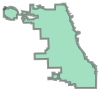

In [ ]:
# Load crime data from three separate TSV files (presumably for different years).
# The paths are relative to the current working directory.
# NOTE: Ensure these files exist in the expected directory.
data_chicago2021=pd.read_csv('Crimes_-_2021_20231019.tsv',sep='\t')
data_chicago2022=pd.read_csv('Crimes_-_2022_20231019.tsv',sep='\t')
data_chicago2023=pd.read_csv('Crimes_-_2023_20231019.tsv',sep='\t')

# Load the Chicago community boundaries GeoJSON file again.
# This file was created and saved in cell 5.
localidades=gpd.read_file('chicago_boundaries_income.geojson')

# Extract the geometry objects from the localities GeoDataFrame into a GeoSeries.
geometrias=gpd.GeoSeries([i for i in localidades.geometry])
# Create a single geometric object by taking the union of all locality geometries.
# This defines the combined geographic boundary of Chicago.
geo=geometrias.unary_union

# Display the resulting combined geometry object (implicit output).
geo

In [ ]:
data_chicago2021.head(2)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12342615,JE202211,04/17/2021 03:20:00 PM,081XX S PRAIRIE AVE,0325,ROBBERY,VEHICULAR HIJACKING,RESIDENCE,True,False,...,6.0,44,03,1179448.0,1851073.0,2021,09/14/2023 03:41:59 PM,41.746626,-87.618032,"(41.746626309, -87.618031954)"
1,26262,JE366265,09/08/2021 04:45:00 PM,047XX W HARRISON ST,0110,HOMICIDE,FIRST DEGREE MURDER,CAR WASH,True,False,...,24.0,25,01A,1144907.0,1896933.0,2021,09/14/2023 03:41:59 PM,41.873191,-87.743447,"(41.873191445, -87.743446563)"


In [ ]:
data_chicago2021[data_chicago2021[['Primary Type','Description','Location']].notnull().all(1)][['Primary Type','Description','Location']].head(6)

,Primary Type,Description,Location
0,ROBBERY,VEHICULAR HIJACKING,"(41.746626309, -87.618031954)"
1,HOMICIDE,FIRST DEGREE MURDER,"(41.873191445, -87.743446563)"
10,BATTERY,DOMESTIC BATTERY SIMPLE,"(41.941161268, -87.642667917)"
11,BATTERY,DOMESTIC BATTERY SIMPLE,"(41.872326358, -87.679953348)"
12,DECEPTIVE PRACTICE,FRAUD OR CONFIDENCE GAME,"(41.991164132, -87.776656659)"
13,BATTERY,DOMESTIC BATTERY SIMPLE,"(42.017140356, -87.666892219)"


In [ ]:
data_chicago2021['Primary Type'].unique()

array(['ROBBERY', 'HOMICIDE', 'SEX OFFENSE', 'DECEPTIVE PRACTICE',
       'CRIMINAL SEXUAL ASSAULT', 'OFFENSE INVOLVING CHILDREN', 'BATTERY',
       'BURGLARY', 'THEFT', 'MOTOR VEHICLE THEFT', 'ASSAULT',
       'OTHER OFFENSE', 'CRIMINAL TRESPASS', 'PUBLIC PEACE VIOLATION',
       'CRIMINAL DAMAGE', 'NARCOTICS', 'STALKING', 'OBSCENITY',
       'WEAPONS VIOLATION', 'LIQUOR LAW VIOLATION',
       'INTERFERENCE WITH PUBLIC OFFICER', 'KIDNAPPING',
       'CONCEALED CARRY LICENSE VIOLATION', 'INTIMIDATION', 'ARSON',
       'PROSTITUTION', 'PUBLIC INDECENCY', 'OTHER NARCOTIC VIOLATION',
       'GAMBLING', 'NON-CRIMINAL', 'HUMAN TRAFFICKING'], dtype=object)

In [ ]:
data_chicago2022['Primary Type'].unique()

array(['SEX OFFENSE', 'OTHER OFFENSE', 'WEAPONS VIOLATION', 'THEFT',
       'BATTERY', 'CRIMINAL SEXUAL ASSAULT', 'ROBBERY', 'BURGLARY',
       'ARSON', 'OFFENSE INVOLVING CHILDREN', 'DECEPTIVE PRACTICE',
       'ASSAULT', 'MOTOR VEHICLE THEFT', 'NARCOTICS', 'CRIMINAL DAMAGE',
       'INTIMIDATION', 'STALKING', 'CRIMINAL TRESPASS', 'HOMICIDE',
       'OBSCENITY', 'PUBLIC PEACE VIOLATION', 'PROSTITUTION',
       'INTERFERENCE WITH PUBLIC OFFICER', 'LIQUOR LAW VIOLATION',
       'KIDNAPPING', 'CONCEALED CARRY LICENSE VIOLATION',
       'HUMAN TRAFFICKING', 'OTHER NARCOTIC VIOLATION', 'GAMBLING',
       'NON-CRIMINAL', 'PUBLIC INDECENCY'], dtype=object)

In [ ]:
data_chicago2023['Primary Type'].unique()

array(['CRIMINAL DAMAGE', 'DECEPTIVE PRACTICE', 'CRIMINAL SEXUAL ASSAULT',
       'THEFT', 'OFFENSE INVOLVING CHILDREN', 'SEX OFFENSE', 'STALKING',
       'MOTOR VEHICLE THEFT', 'CRIMINAL TRESPASS', 'BATTERY',
       'OTHER OFFENSE', 'ASSAULT', 'PROSTITUTION', 'BURGLARY',
       'NARCOTICS', 'ROBBERY', 'KIDNAPPING', 'ARSON',
       'CONCEALED CARRY LICENSE VIOLATION', 'WEAPONS VIOLATION',
       'INTERFERENCE WITH PUBLIC OFFICER', 'PUBLIC PEACE VIOLATION',
       'HOMICIDE', 'LIQUOR LAW VIOLATION', 'INTIMIDATION', 'GAMBLING',
       'OBSCENITY', 'HUMAN TRAFFICKING', 'OTHER NARCOTIC VIOLATION',
       'PUBLIC INDECENCY', 'NON-CRIMINAL'], dtype=object)

### 10. Filter Crime Data for Theft and Valid Coordinates
This block filters the loaded crime data DataFrames for each year (data_chicago2021, data_chicago2022, data_chicago2023) to include only crime incidents where the 'Primary Type' contains "THEFT" and where both Latitude and Longitude coordinates are present (not null). The filtering is performed in-place.

In [ ]:
# Filter the 2021 crime data: keep rows where 'Primary Type' contains 'THEFT' AND Latitude/Longitude are not null.
# engine='python' is used for the query. inplace=True modifies the DataFrame directly.
data_chicago2021.query(" (`Primary Type`.str.contains('THEFT')) and (Latitude.notnull()) and (Longitude.notnull()) "
                       , engine='python'
                       , inplace=True)
# Filter the 2022 crime data using the same criteria.
data_chicago2022.query(" (`Primary Type`.str.contains('THEFT')) and (Latitude.notnull()) and (Longitude.notnull()) "
                       , engine='python'
                       , inplace=True)
# Filter the 2023 crime data using the same criteria.
data_chicago2023.query(" (`Primary Type`.str.contains('THEFT')) and (Latitude.notnull()) and (Longitude.notnull()) "
                       , engine='python'
                       , inplace=True)


data_chicago2021['Primary Type'].unique(),data_chicago2022['Primary Type'].unique(),data_chicago2023['Primary Type'].unique()

(array(['MOTOR VEHICLE THEFT', 'THEFT'], dtype=object),
 array(['THEFT', 'MOTOR VEHICLE THEFT'], dtype=object),
 array(['THEFT', 'MOTOR VEHICLE THEFT'], dtype=object))

### 11. Combine and Reproject Crime Data Points
This block selects relevant columns from the filtered crime data for each year, concatenates them into a single DataFrame, and converts this DataFrame into a GeoDataFrame. It then assigns the initial coordinate system and reprojects the data to a planar coordinate system suitable for spatial analysis, finally extracting the projected coordinates into new columns.

In [ ]:
# Select only the 'Date', 'Longitude', and 'Latitude' columns from the filtered yearly DataFrames.
data_chicago2021=data_chicago2021[['Date','Longitude','Latitude']]
data_chicago2022=data_chicago2022[['Date','Longitude','Latitude']]
data_chicago2023=data_chicago2023[['Date','Longitude','Latitude']]

# Concatenate the filtered yearly DataFrames into a single DataFrame.
data_chicago=pd.concat([data_chicago2021,data_chicago2022,data_chicago2023])

# Create a list of Point objects from the Longitude (column 1) and Latitude (column 2) of the combined DataFrame.
geometria=[ Point(data_chicago.iloc[i,1],data_chicago.iloc[i,2]) for i in range(len(data_chicago))]

# Create a new GeoDataFrame using the combined DataFrame and the list of Point objects as the geometry.
geo_pandas_chic=gpd.GeoDataFrame(data=data_chicago,geometry=geometria)

# Assign the initial Coordinate Reference System (CRS) to the GeoDataFrame (WGS 84, standard lat/lon).
geo_pandas_chic.crs = 'EPSG:4326'

# Reproject the GeoDataFrame to a planar CRS (EPSG:26971, NAD83 / Illinois East, suitable for Chicago).
# This is necessary for accurate spatial measurements.
geo_pandas_chic_planas = geo_pandas_chic.to_crs(epsg=26971)

# Extract the x and y coordinates from the reprojected planar geometry and store them in new columns.
geo_pandas_chic_planas['coord_x']=geo_pandas_chic_planas.geometry.apply(lambda x: x.x)
geo_pandas_chic_planas['coord_y']=geo_pandas_chic_planas.geometry.apply(lambda x: x.y)

# Display the first few rows of the reprojected GeoDataFrame with new coordinate columns (implicit output).
geo_pandas_chic_planas.head()

,Date,Longitude,Latitude,geometry,coord_x,coord_y
63,10/11/2021 05:53:00 PM,-87.765659,41.902370,POINT (347102.972 581414.783),347102.971836,581414.782872
83,12/12/2021 02:00:00 PM,-87.658995,41.766087,POINT (356072.339 566342.088),356072.339305,566342.087905
145,01/10/2021 07:30:00 PM,-87.719513,41.906343,POINT (350928.829 581882.347),350928.829061,581882.346949
167,02/19/2021 07:00:00 AM,-87.824155,41.937785,POINT (342225.857 585317.755),342225.857266,585317.754592
172,03/17/2021 01:00:00 PM,-87.806319,41.925712,POINT (343713.284 583985.776),343713.284197,583985.776024


### 12. Prepare Data for OpenCP and Save Processed Objects
This block converts the reprojected crime data points into the open_cp.TimedPoints format required by the open_cp library. It then re-processes the Chicago community geometries to create the overall geographic boundary and the reprojected community GeoDataFrame. Finally, it saves the open_cp.TimedPoints object, the geographic boundary, and the reprojected communities GeoDataFrame to pickle and GeoJSON files for later use.

In [ ]:
# Parse the 'Date' column into datetime objects.
timestamps = geo_pandas_chic_planas.Date.map(dateutil.parser.parse)
# Extract the reprojected x and y coordinates into numpy arrays.
xcoords, ycoords = (geo_pandas_chic_planas.coord_x.values, geo_pandas_chic_planas.coord_y.values)

# Create an open_cp.TimedPoints object from the timestamps and coordinates.
crime_point_chic_opencp = open_cp.TimedPoints.from_coords(timestamps, xcoords, ycoords)

# Re-process locality data (CRS assignment, reprojection, geometry union).
# NOTE: This data was processed similarly in previous cells but is reloaded/reprojected here.
localidades.crs = 'EPSG:4326' # Assign initial CRS
localidades_planas = localidades.to_crs(epsg=26971) # Reproject to planar CRS (using Chicago's CRS)
geometrias=gpd.GeoSeries([i for i in localidades_planas.geometry]) # Get reprojected geometries
geo=geometrias.unary_union # Union geometries to get combined boundary

# Save key processed data objects to files for later use.
# File paths are relative to the current working directory.
# NOTE: Ensure the target directory is writable.
pkl.dump(crime_point_chic_opencp, open('data_chicago_opencp.pkl', "wb")) # Save TimedPoints object
pkl.dump(geo, open('geo_chicago.pkl', "wb")) # Save combined boundary geometry
pkl.dump(localidades_planas, open('chicago_community_filtrada_planas.pkl', "wb")) # Save reprojected communities GeoDataFrame

# Save the GeoDataFrames to GeoJSON files.
# NOTE: Ensure the target directory is writable.
localidades_planas.to_file('chicago_community_filtrada_planas.geojson',driver='GeoJSON') # Save reprojected communities GeoDataFrame
geo_pandas_chic_planas.to_file('data_chichago_community_planas.geojson',driver='GeoJSON') # Save crime points GeoDataFrame

# Display the shape (number of rows, number of columns) of the crime points GeoDataFrame (implicit output).
geo_pandas_chic_planas.shape

(189954, 6)

### 13. Define Analysis Region and Grid
This block reloads the filtered and reprojected Chicago community data and its combined boundary. It calculates the bounding box of this boundary and uses these bounds to define a rectangular analysis region and a spatial grid with specified cell sizes. Finally, it masks the grid to include only areas within the geographic boundary.

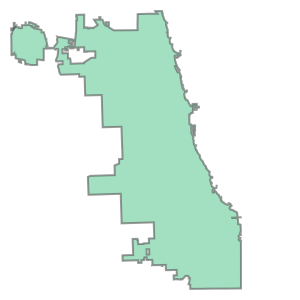

In [ ]:
# Load the filtered and reprojected Chicago community GeoJSON file.
# This reloads the file saved in a previous step.
# The path is relative to the current working directory.
localidades=gpd.read_file('chicago_community_filtrada_planas.geojson')
# Re-create GeoSeries from geometries
geometrias=gpd.GeoSeries([i for i in localidades.geometry])
# Re-create the union geometry object representing the total boundary
geo=geometrias.unary_union

# Comment indicating the purpose: Generating Grid for algorithms.

# Calculate min/max bounds from the boundary geometry.
minx=geo.bounds[0]
miny=geo.bounds[1]
maxx=geo.bounds[2]
maxy=geo.bounds[3]

# Calculate the size of the bounding box in x and y directions, rounded to the nearest 1000 units.
# This seems intended for defining the extent of the region based on the data bounds.
x_size=np.round((maxx-minx)/1000,0)
y_size=np.round((maxy-miny)/1000,0)

# Calculate the absolute range of coordinates and find the maximum range.
x_range=abs(maxx-minx)
y_range=abs(maxy-miny)
range_max=max(x_range,y_range)

# Define a rectangular region for analysis using calculated minx/miny and sizes based on rounded bounds.
# This region covers the extent of the data based on the calculated sizes.
region = open_cp.RectangularRegion(xmin=minx, xmax=minx+x_size*1000, ymin=miny, ymax=miny+y_size*1000)

# Define a spatial grid with specified cell size (1000x1000) starting from minx/miny.
grid = open_cp.data.Grid(xsize=1000, ysize=1000, xoffset=minx, yoffset=miny)
# Mask the grid using the geographic boundary (geo).
# This keeps only the grid cells that intersect with the defined region.
grid2 = open_cp.geometry.mask_grid_by_intersection(geo, grid)


geo

### 14. Save Defined Spatial Objects
This block creates a GeoDataFrame representing the bounding box of the analysis region's boundary. It then saves this bounding box GeoDataFrame as a GeoJSON file and saves the defined rectangular region, the masked grid, and the unmasked grid objects as pickle files. These saved files store the key spatial configurations determined in previous steps for potential reuse.

In [ ]:
# Create a GeoDataFrame for the bounding box of the 'geo' boundary.
# The polygon is created using the bounds (minx, miny, maxx, maxy) obtained from the projected 'geo' object.
bounding=gpd.GeoDataFrame({'geometry':[Polygon([(geo.bounds[0], geo.bounds[1])
                        , (geo.bounds[0], geo.bounds[3])
                        , (geo.bounds[2], geo.bounds[3])
                        , (geo.bounds[2], geo.bounds[1])])]})
# Set the CRS of the bounding box GeoDataFrame.
# NOTE: The polygon coordinates are from the projected 'geo' (EPSG:26971), but the CRS is set to EPSG:4326 (lat/lon), which might be incorrect.
bounding.crs = "EPSG:4326"
# Save the bounding box GeoDataFrame to a GeoJSON file.
# The path is relative to the current working directory.
# NOTE: Ensure the target directory is writable.
bounding.to_file('chicago_bounding_box.geojson',driver='GeoJSON')

# Save the defined region and grid objects to pickle files.
# These paths are relative to the current working directory.
# NOTE: Ensure the target directory is writable.
pkl.dump(region, open('chicago_definition_region.pkl', "wb")) # Save the RectangularRegion object
pkl.dump(grid2, open('chicago_grilla1_region.pkl', "wb")) # Save the masked grid object
pkl.dump(grid, open('chicago_grilla2_region.pkl', "wb")) # Save the unmasked grid object

# Display the bounding box GeoDataFrame (implicit output).
bounding


,geometry
0,"POLYGON ((332577.32458 552875.35377, 332577.32..."


### 15. Load Spatial Objects and Setup Mask
This block loads previously saved spatial configuration objects (grids, region, geographic boundary, and localities) from files. It then calculates coordinate boundaries based on the geographic boundary and defines grid cell dimensions to initialize an empty NumPy array intended for use as a mask.

In [ ]:
# Load previously saved grid, region, geo boundary, and localities objects from files.
# File paths are relative to the current working directory.
grid1=pkl.load(open('chicago_grilla1_region.pkl', "rb")) # Load the masked grid
grid2=pkl.load(open('chicago_grilla2_region.pkl', "rb")) # Load the unmasked grid
region=pkl.load(open('chicago_definition_region.pkl', "rb")) # Load the rectangular region
geo=pkl.load(open('geo_chicago.pkl', "rb")) # Load the combined geographic boundary
localidades=gpd.read_file('chicago_community_filtrada_planas.geojson') # Load the reprojected communities GeoDataFrame


# Comment indicating the purpose: Coordenadas geográficas

# Calculate two coordinate points based on the bounds of the 'geo' boundary and sizes based on rounded bounds.
# These points define the corners of the area for which the mask is created.
# NOTE: x_size and y_size are assumed to be defined in a previous cell (cell 13).
inferior = (geo.bounds[0], geo.bounds[1]) # Bottom-left corner (based on geo bounds)
superior = (geo.bounds[0]+x_size*1000, geo.bounds[1]+y_size*1000) # Top-right corner (based on geo bounds + calculated size)

# Define the length and width of a grid cell in the projected coordinates (likely meters).
longitud=1000 # Cell size in x-direction
ancho=1000 # Cell size in y-direction

# Create an empty NumPy array with dimensions calculated based on the total range and cell size.
# This array's shape corresponds to the number of grid cells needed to cover the area from 'inferior' to 'superior' with 'longitud'x'ancho' cells.
mask = np.empty([ int((superior[1] - inferior[1]) / ancho) , int((superior[0] - inferior[0]) / longitud)])
# Display the shape (dimensions) of the created mask array (implicit output).
mask.shape


(42, 35)

### 16. Build Grid GeoDataFrame and Create Community Mask
This block constructs a GeoDataFrame representing a grid of polygons covering the analysis area. Simultaneously, it iterates through each grid cell, checks which community (from the filtered communities data) it intersects, and builds a list of lists (mask) containing the community name for each cell, using 0 if no community intersects. This process creates both a geometric representation of the grid and a corresponding grid-like mask indicating the community of each cell.

In [ ]:
# Initialize counters and an empty GeoDataFrame to build the grid.
county=0 # Row counter for the grid
cuadricula_chic=gpd.GeoDataFrame() # GeoDataFrame to store grid cell polygons
mask=[] # Re-initialize mask as an empty list (overwrites any previous 'mask' variable)

# Loop through the rows and columns corresponding to the dimensions calculated based on the region size.
# This iterates through each potential grid cell in the defined area.
# NOTE: superior, inferior, ancho, and longitud are assumed to be defined in a previous cell (cell 15).
for y in tqdm(range(int((superior[1] - inferior[1]) / ancho))): # Outer loop for rows (y-direction) with progress bar
  countx=0 # Column counter for the current row
  vector_x=[] # List to store community names (or 0) for the current row

  for x in range(int((superior[0] - inferior[0]) / longitud)): # Inner loop for columns (x-direction)
    # Calculate the coordinates for the vertices of the current grid cell (square).
    xmin = inferior[0] + x * longitud
    xmax = xmin + longitud
    ymin = inferior[1] + y * ancho
    ymax = ymin + ancho

    # Create a Polygon object for the current grid cell.
    square = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)])

    # Create a temporary GeoDataFrame for the current square and concatenate it to the main grid GeoDataFrame.
    cuadricula_chic=pd.concat([cuadricula_chic,gpd.GeoDataFrame({'geometry':[square]})])

    # Try to find which community the current grid cell intersects and get its name.
    try:
      # Commented out: Original attempt to populate a 2D mask array directly.
      # mask[countx][county]=localidades[square.intersects(localidades.geometry)].reset_index(drop=True)["LocCodigo"][0]

      # Filter localities (communities) to find those intersecting the current square, reset index, and get the 'community' name of the first intersecting community.
      # Append the found community name to the vector_x list for the current row.
      vector_x.append(localidades[square.intersects(localidades.geometry)].reset_index(drop=True)["community"][0])
    except:
      # If no community intersects or an error occurs, append 0 to the vector_x list.
      vector_x.append(0)
      continue # Continue to the next grid cell in the inner loop.

    countx+=1 # Increment column counter
  # After processing a row (inner loop finishes), append the vector of community names (or 0) for the row to the main mask list.
  # NOTE: np.transpose(vector_x) on a 1D list does not change the list. This appends the list itself.
  mask.append(np.transpose(vector_x))
  county+=1 # Increment row counter (outer loop)


100%|██████████| 42/42 [00:15<00:00,  2.72it/s]


### 17. Finalize Community Mask, Save Spatial Objects, and Define Regions
This block converts the list-based community mask into a NumPy array of strings, assigns the correct CRS to the grid GeoDataFrame, and saves both the grid GeoDataFrame and the mask array to files. It also defines lists containing the specific Chicago community names designated as 'protected' and 'unprotected' regions based on prior analysis (income). Finally, it creates and saves boolean masks based on these region definitions and the community mask.

In [ ]:
# Convert the list 'mask' (populated with community names or '0' per grid cell row) into a NumPy array and cast to string type.
# This creates the final 2D grid representation of community names/codes.
mask=np.array(mask).astype(str)
# Display the shape (dimensions) of the finalized mask NumPy array (implicit output).
mask.shape

# Assign the Coordinate Reference System (CRS) to the grid GeoDataFrame.
# EPSG:26971 is the projected CRS used for Chicago.
cuadricula_chic.crs = "EPSG:26971"
# Save the grid GeoDataFrame to a GeoJSON file.
# The path is relative to the current working directory.
# NOTE: Ensure the target directory is writable.
cuadricula_chic.to_file('cuadricula_1km_chicago_planas.geojson',driver='GeoJSON')
# Save the NumPy array mask (containing community names/codes per grid cell) to a pickle file.
# The path is relative to the current working directory.
# NOTE: Ensure the target directory is writable.
pkl.dump(mask, open('chicago_mascara_localidades.pkl', "wb"))

# Define lists containing strings that correspond to 'protected' and 'unprotected' community names.
# These lists are used to identify grid cells belonging to protected/unprotected areas using the 'mask' array.
# NOTE: These lists reflect the income-based classification from cell 7.
Protegidos=['OAKLAND', 'FULLER PARK', 'WASHINGTON PARK', 'WOODLAWN',
        'ALBANY PARK', 'BELMONT CRAGIN', 'HERMOSA', 'AVONDALE',
        'HUMBOLDT PARK', 'AUSTIN', 'WEST GARFIELD PARK',
        'EAST GARFIELD PARK', 'NORTH LAWNDALE', 'SOUTH LAWNDALE',
        'LOWER WEST SIDE', 'ARMOUR SQUARE', 'SOUTH SHORE', 'CHATHAM',
        'SOUTH CHICAGO', 'BURNSIDE', 'MCKINLEY PARK', 'ROSELAND',
        'PULLMAN', 'SOUTH DEERING', 'EAST SIDE', 'WEST PULLMAN',
        'RIVERDALE', 'ARCHER HEIGHTS', 'BRIGHTON PARK', 'NEW CITY',
        'WEST ELSDON', 'GAGE PARK', 'WEST LAWN', 'CHICAGO LAWN',
        'WEST ENGLEWOOD', 'ENGLEWOOD', 'GREATER GRAND CROSSING',
        'AUBURN GRESHAM', 'WASHINGTON HEIGHTS']

NoProtegidos=['DOUGLAS', 'GRAND BOULEVARD', 'KENWOOD', 'LINCOLN SQUARE',
        'HYDE PARK', 'ROGERS PARK', 'JEFFERSON PARK', 'FOREST GLEN',
        'NORTH PARK', 'PORTAGE PARK', 'IRVING PARK', 'DUNNING',
        'MONTCLARE', 'WEST RIDGE', 'LOGAN SQUARE', 'WEST TOWN',
        'NEAR WEST SIDE', 'UPTOWN', 'NEAR SOUTH SIDE', 'NORWOOD PARK',
        'NEAR NORTH SIDE', 'LOOP', 'AVALON PARK', 'LAKE VIEW',
        'CALUMET HEIGHTS', 'NORTH CENTER', 'HEGEWISCH', 'GARFIELD RIDGE',
        'BRIDGEPORT', 'CLEARING', 'LINCOLN PARK', 'ASHBURN', 'BEVERLY',
        'MOUNT GREENWOOD', 'MORGAN PARK', 'OHARE', 'EDGEWATER',
        'EDISON PARK']

# Create a boolean mask where True indicates grid cells whose community name is in the 'Protegidos' list.
mask_protegidos=np.isin(mask,Protegidos)
# Create a boolean mask where True indicates grid cells whose community name is in the 'NoProtegidos' list.
mask_noprotegidos=np.isin(mask,NoProtegidos)
# Create a boolean mask where True indicates grid cells whose community code/name is '0' (no intersection).
mask_zeros=np.isin(mask,['0'])

# Save the generated boolean masks to pickle files for later use.
# File paths are relative to the current working directory.
# NOTE: Ensure the target directory is writable.
pkl.dump(mask_protegidos, open('chichago_mascara_protegidos.pkl', "wb")) # Save mask for protected regions
pkl.dump(mask_noprotegidos, open('chichago_mascara_noprotegidos.pkl', "wb")) # Save mask for non-protected regions
pkl.dump(mask_zeros, open('chichago_mascara_zeros.pkl', "wb")) # Save mask for zero-coded regions


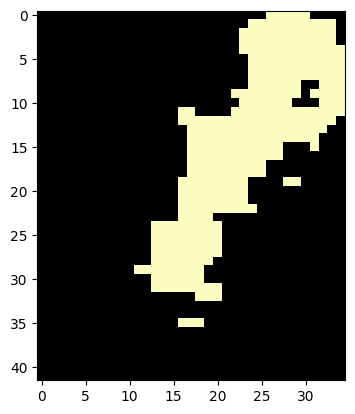

In [ ]:
#plot protected mask
plt.imshow( mask_protegidos , cmap = 'magma')

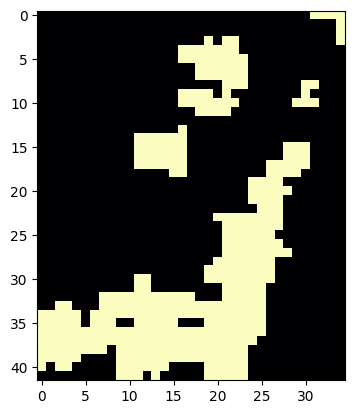

In [ ]:
#plot unprotected mask
plt.imshow( mask_noprotegidos , cmap = 'magma')

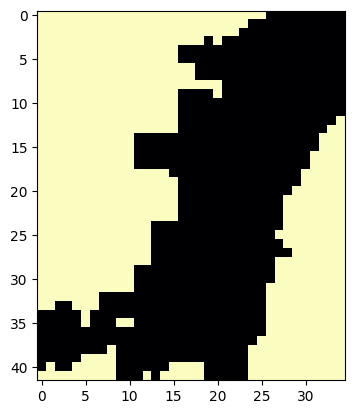

In [ ]:
#plot others mask
plt.imshow( mask_zeros , cmap = 'magma')

### 18. Define Event Plotting Utility and Load/Filter Data by Date
This block defines a helper function plot_events to visualize spatio-temporal point data. It then loads the open_cp.TimedPoints crime data object that was saved previously and filters this data to include only events from the start of 2021 onwards, preparing it for subsequent analysis within this time window.

In [ ]:
# Import plotting library
import matplotlib.pyplot as plt
# Define a helper function to plot spatio-temporal event data.
# Takes TimedPoints data and date range limits for the time axis.
def plot_events(data,f_inicial,f_final):
    # Data is assumed to be raw TimedPoints data.
    # Create a figure with two subplots side-by-side.
    fig, ax = plt.subplots(ncols=2, figsize=(9,2.5))

    # Plot event coordinates (x vs y) on the first subplot.
    ax[0].scatter(data.xcoords, data.ycoords, marker="+", alpha=0.5)
    ax[0].set_title("Coordinates")
    ax[0].set_xlabel('Coordinate X')
    ax[0].set_ylabel('Coordinate Y')
    # Commented-out: Set x and y limits
    # ax[0].set(xlim=[0,1], ylim=[0,1])

    # Get event timestamps.
    times = data.times_datetime()
    # Plot time vs y-coordinate on the second subplot.
    ax[1].scatter(times, data.ycoords, marker="+", alpha=0.1)
    # Set x-axis limits based on the provided date range.
    ax[1].set_xlim([f_inicial, f_final])
    # Commented-out: Set y-limits
    # ax[1].set_ylim([0, 1])
    ax[1].set_title("Coordinate Vs Dates")
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Coordinate Y')
    # Automatically format the x-axis to display dates nicely.
    fig.autofmt_xdate()
    None # Placeholder

# Load the crime data in open_cp.TimedPoints format from a pickle file.
# This reloads the object saved in cell 12.
# The path is relative to the current working directory.
crime_point_chic_opencp = pkl.load(open("data_chicago_opencp.pkl", "rb")) ## cargar datos

# Filter the TimedPoints object to keep only events from January 1, 2021 onwards.
crime_point_chic_opencp=crime_point_chic_opencp[(crime_point_chic_opencp.times_datetime()>=np.datetime64("2021-01-01 00:00:00"))]

# Display the number of events (length of x-coordinates) in the filtered TimedPoints object (implicit output).
len(crime_point_chic_opencp.xcoords)


189954

### 19. Split Data into Training and Testing Sets
This block splits the crime data (crime_point_chic_opencp) into temporal training and testing sets based on specific date ranges. Events in 2022 form the training set (Train_chic), and events from 2023 onwards form the testing set (Test_chic). Both resulting open_cp.TimedPoints objects are then saved to pickle files.

In [ ]:
# Create a boolean mask for timestamps within the training period (2022).
mask_times_train=((crime_point_chic_opencp.times_datetime()>=np.datetime64("2022-01-01 00:00:00")) & (crime_point_chic_opencp.times_datetime()<=np.datetime64("2022-12-31 00:00:00")))
# Create a boolean mask for timestamps within the testing period (2023 onwards).
mask_times_test=((crime_point_chic_opencp.times_datetime()>=np.datetime64("2023-01-01 00:00:00")) )

# Filter the crime data using the training mask to create the training set.
Train_chic=crime_point_chic_opencp[mask_times_train]
# Print the number of events in the training set.
print(len(Train_chic.xcoords))

# Save the training set to a pickle file.
# The path is relative to the current working directory.
pkl.dump(Train_chic, open("Train_chicago.pkl", "wb"))

# Filter the crime data using the testing mask to create the testing set.
Test_chic=crime_point_chic_opencp[mask_times_test]
# Print the number of events in the testing set.
print(len(Test_chic.xcoords))
# Save the testing set to a pickle file.
# The path is relative to the current working directory.
pkl.dump(Test_chic, open("Test_chicago.pkl", "wb"))

74279
65822


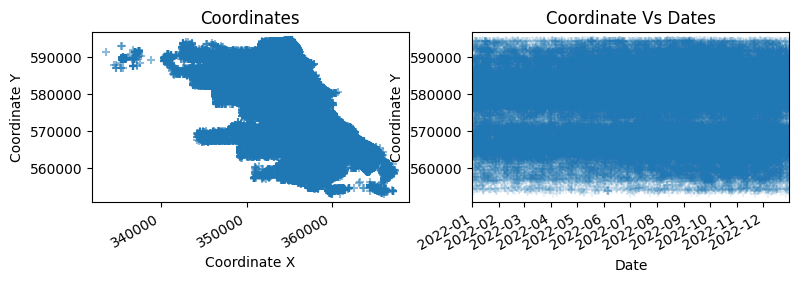

In [ ]:
plot_events(Train_chicago,*Train_chicago.time_range)

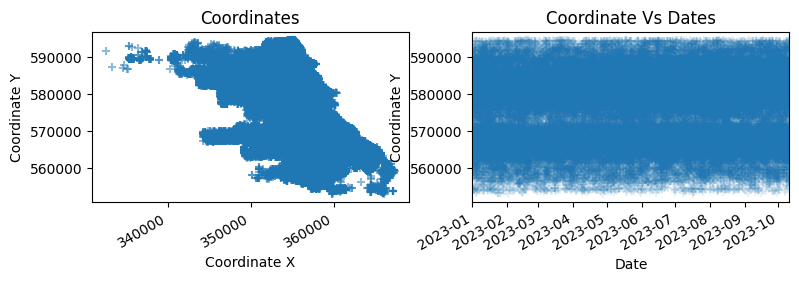

In [ ]:
plot_events(Test_chicago,*Test_chicago.time_range)

### 20. Load Data and Define Utilities for Prediction
This block loads the necessary spatial region and crime data objects that were previously saved. It also defines (or re-defines) utility functions (intensity_m and get_real_m) used to process model predictions and real event data into a standardized grid format. Finally, it generates a sequence of dates (t) which will be used as prediction dates in the subsequent modeling loop.

In [ ]:
# Import model classes and time unit utilities
from models.model_selection import NAIVE_MODEL, KDE_MODEL, SEPP_MODEL
from open_cp.sources.sepp import make_time_unit
from global_vars import days_time_unit
from datetime import timedelta

# Load the rectangular analysis region object from a pickle file.
# The path is relative to the current working directory.
region = pkl.load(open("chicago_definition_region.pkl", "rb")) ## cargar datos
# Load the full crime data in open_cp.TimedPoints format from a pickle file.
# The path is relative to the current working directory.
crime_point_chic = pkl.load(open("data_chicago_opencp.pkl", "rb")) ## cargar datos

# Function to convert model prediction to normalized intensity matrix
# Handles continuous or grid-based predictions and normalizes the output.
def intensity_m(model,date,region,grid_size):
    try:
        # Get prediction (with or without date)
        predict=model.predict(date)
    except:
        predict=model.predict()

    try:
        # Convert continuous prediction to grid
        M=open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(predict, region, grid_size, grid_size)
        intensity_matrix= M.intensity_matrix
    except:
        # If already grid-based, get matrix
        intensity_matrix = predict.intensity_matrix

    # Normalize unless sum is zero
    if intensity_matrix.sum()==0:
        return intensity_matrix
    else:
        return intensity_matrix/intensity_matrix.sum()

### Function to get real data intensity matrix
import open_cp.naive as naive
# Function to convert real event data for a day into a normalized grid
# Filters events for the day and counts them in a grid.
def get_real_m(timedpoints,p_date,grid_size,region):
    # Filter events for the specific date
    real = timedpoints[(timedpoints.times_datetime()>=p_date) & ((timedpoints.times_datetime()<p_date+timedelta(days=1)))]
    # Create counting grid predictor
    predictor = naive.CountingGridKernel(grid_size,grid_size,region=region) # Note: grid_size appears twice
    # Set data for predictor
    predictor.data = real
    try:
        # Predict, re-normalize, and get matrix
        gridpred = predictor.predict().renormalise()
        real=gridpred.intensity_matrix.data
        return real
    except:
        # If re-normalization fails, return raw matrix
        return predictor.predict().intensity_matrix

# Generate a sequence of dates from Dec 1, 2021 to Oct 1, 2023 (exclusive of end date).
# This sequence 't' will be used to iterate through prediction dates.
t=np.arange(datetime(2021,12,1,0,0),datetime(2023,10,1,0,0),timedelta(days=1)).astype(datetime)


Failed to load 'descartes' package.


### 21. Generate SEPP Predictions and Real Data Grids (Sliding Window)
This block implements the core logic for generating SEPP model predictions and corresponding real data grids over the sequence of time points (t). It uses a 30-day sliding window of past data for training the model at each prediction date. Results are saved incrementally to pickle files.

In [ ]:
# Import SEPP specific modules
import open_cp.seppexp as sepp
#import open_cp.sepp as sepp # Commented out alternative import

# Note: intensity_m and get_real_m functions are assumed to be defined in a previous cell.
# Note: crime_point_chic, region, and t are assumed to be defined in previous cells.

# Check if prediction results file exists in the 'SEPP/' directory; load if it does, otherwise initialize empty dictionary.
# File path is relative to the current working directory.
if not os.path.exists(os.path.join("SEPP/","predictions_window.pkl")):
    predictions={}
else:
    predictions=pkl.load(open(os.path.join("SEPP/","predictions_window.pkl"), "rb"))

# Check if real data grids file exists in the 'SEPP/' directory; load if it does, otherwise initialize empty dictionary.
# File path is relative to the current working directory.
if not os.path.exists(os.path.join("SEPP/","reals_window.pkl")):
    reals={}
else:
    reals=pkl.load(open(os.path.join("SEPP/","reals_window.pkl"), "rb"))


# Iterate through each time point 'i' in the sequence 't'.
for i in tqdm(t): # tqdm provides a progress bar
    #pred_date=Test_bog.time_range[0].astype(datetime.datetime).date()+timedelta(days=i) # Commented out alternative date calculation

    # Define the start and end dates for the 30-day sliding window (t1 to t2).
    t1=i-timedelta(days=30)
    t2=i
    # Filter the full crime data ('crime_point_chic') to get events within the current sliding window (training data).
    train_filter=crime_point_chic[(crime_point_chic.times_datetime()>=t1) & (crime_point_chic.times_datetime()<t2)]

    # Use a try-except block to handle potential errors during SEPP model training.
    try:
        # Initialize the SEPPTrainer with the region and grid size (1000).
        trainer = sepp.SEPPTrainer(region, grid_size=1000)
        # Set the training data for the trainer.
        trainer.data = train_filter
        # Train the SEPP model for a specified number of iterations (50).
        sepp_model_result = trainer.train(iterations=50)
        # Set the training data on the resulting model object (might be needed for prediction).
        sepp_model_result.data = train_filter
    except:
        # If training fails, print an error message and skip to the next iteration.
        print('Error in ',i)
        continue

    # Set the prediction date for the current iteration.
    pred_date=i
    # If prediction for the current date is not already in the 'predictions' dictionary:
    if not pred_date in predictions:
        # Generate the normalized intensity matrix prediction using the trained SEPP model and intensity_m function.
        # NOTE: The intensity_m function is assumed to be defined in a previous cell.
        predict=intensity_m(sepp_model_result,pred_date,region,1000)
        # Store the prediction matrix in the 'predictions' dictionary with the prediction date as key.
        predictions[pred_date]=predict

    # If real data grid for the current date is not already in the 'reals' dictionary:
    if not pred_date in reals:
        # Get the normalized real data intensity matrix for the prediction date using the get_real_m function.
        # The get_real_m function is assumed to be defined in a previous cell.
        real=get_real_m(crime_point_chic,pred_date,1000,region)
        # Store the real data matrix in the 'reals' dictionary with the prediction date as key.
        reals[pred_date]=real

    # Save the updated predictions and reals dictionaries to pickle files after each iteration.
    # This provides incremental saving in case of interruption.
    # Paths are relative to the current working directory.
    # NOTE: Ensure the 'SEPP/' directory exists before running this code.
    pkl.dump(predictions, open(os.path.join("SEPP/","predictions_window.pkl"), "wb"))
    pkl.dump(reals, open(os.path.join("SEPP/","reals_window.pkl"), "wb"))


100%|██████████| 669/669 [41:57:02<00:00, 225.74s/it]    
